## Temperature modelling

We want to model the temperature $T$ as a function of depth $z$ and time $t$, governed by the Laplace equation

$$
\frac{\partial u}{\partial t} = \nabla\cdot(a \nabla u)
$$

with the temperature conduction $a$, which is a function of heat conduction $\lambda$, the density $\varrho$ and the heat capacity $c$:
$$
a = \frac{\lambda}{\varrho c}
$$

As upper boundary condition, we assume a sinusoidal behaviour
$$
T(z=0, t) = T_0 + \Delta T \sin(\omega t)
$$

with an amplitude of $\Delta T$ around a mean temperature $T0$ and an angular frequency of $\omega=2\pi/T=2\pi/86400s$.
Note that the time zero starts in spring at mean temperature. To use real times, one would have to add a phase shift to the argument of the sine.

The lower boundary condition could be either of Dirichlet type ($T(z_1)=T_0$) or of Neumann type ($dT/dz(z_1)=0$).

For this model, there is an analytical solution
$$
T(z,t) = T_0 + \Delta T \exp(-z/d) \sin(\omega t - z/d)
$$
with the damping depth $d=\sqrt{2a/\omega}$.


For water, we have 
* heat conduction of $\lambda=0.6$ W/(m K)
* density of $\varrho$=1000 kg/m³
* heat capacity of $c$=4.18 kWs/(kg K)
and thus a temperature conduction coefficient of $a$=1.435e-7 m²/s

We consider a mixture of water and sand with the fully saturated porosity $\Phi$.

For sand, we assume 
* $\lambda$=0.25 W/(m K)
* $\varrho$=1550 kg/m³
* $c$=830 Ws/(kg K)

So we can compute the temperature coefficient for a porosity of 35%.

In [145]:
rhoW = 1000 # kg/m³
lamdaW = 0.6 # W (m K)
cW = 4180  # Ws/(kg K)
aW = lamdaW / rhoW / cW
rhoS = 2200
lamdaS = 0.25
cS = 830
aS = lamdaS / rhoS / cS
phi = 0.3
lamda = lamdaW * phi + lamdaS * (1-phi)
rho = rhoW * phi + rhoS * (1-phi)
c = cW * phi + cS * (1-phi)
a = lamda / rho / c
aMix = aW * phi + aS * (1-phi)
print(a, aMix)

1.0514157090392133e-07 1.389000979996541e-07


We now want to model this numerically with Finite Elements using pyGIMLi.

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

In [147]:
x = np.arange(0, 6, 0.1)
mesh = pg.createGrid(x)
print(mesh)

Mesh: Nodes: 60 Cells: 59 Boundaries: 60


In [148]:
day = 60. * 60 * 24  # in s
year = day * 365
omega = 2 * np.pi / year  # day
T0 = 10
dT = 8
d = np.sqrt(a * 2 / omega)
print(f"Temperature damping depth d={d:.2f}m")

Temperature damping depth d=1.03m


The initial condition is the analytical solution for $t$=0:
$$
T(z,t=0) = T_0 + \Delta T \exp(-z/d) \sin(-z/d)
$$

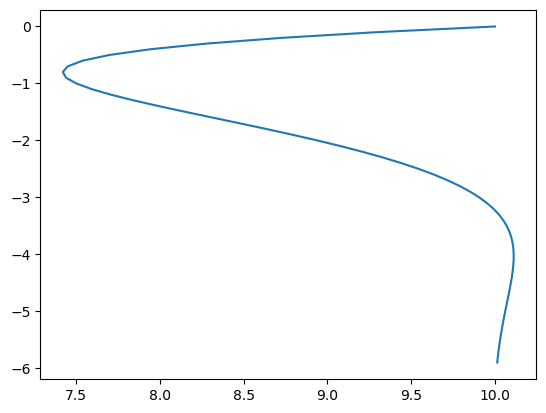

In [149]:
u0 = np.exp(-x/d) * np.sin(-x/d) * dT + T0
pl = plt.plot(u0, -x)

In [150]:
def upperSurface(pos, time=0):
    return np.sin(time*omega)*dT + T0

t = np.arange(0, 2*year, day/10)
T = pg.solver.solveFiniteElements(
    mesh, a=a, times=t, dynamic=True, u0=u0,
    bc=dict(Dirichlet={1: upperSurface}))

Text(0, 0.5, 'depth (m)')

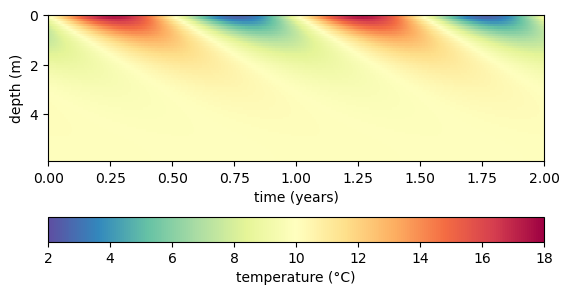

In [151]:
fig, ax = plt.subplots()
kw = dict(extent=[0, 2, max(x), min(x)], vmin=2, vmax=18,
          interpolation="nearest", cmap="Spectral_r")
im = ax.imshow(T.T, **kw)
fig.colorbar(im, orientation="horizontal", label="temperature (°C)")
ax.set_aspect(.1)
ax.set_xlabel("time (years)")
ax.set_ylabel("depth (m)")

Text(0.5, 1.0, 'analytical')

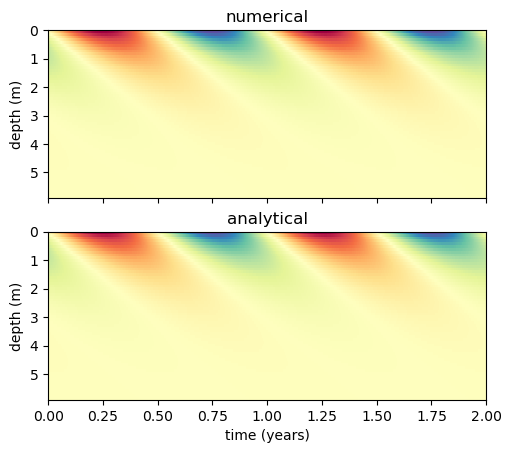

In [152]:
z = np.reshape(x, [1, -1])
Tana = np.sin(np.reshape(t, [-1, 1])*omega - z/d) * np.exp(-z/d) * dT + T0
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
ax[0].imshow(T.T, **kw)
ax[1].imshow(Tana.T, **kw)
for aa in ax: 
    aa.set_aspect(.13)
    aa.set_ylabel("depth (m)")
ax[1].set_xlabel("time (years)")

ax[0].set_title("numerical")
ax[1].set_title("analytical")

Text(0, 0.5, 'depth (m)')

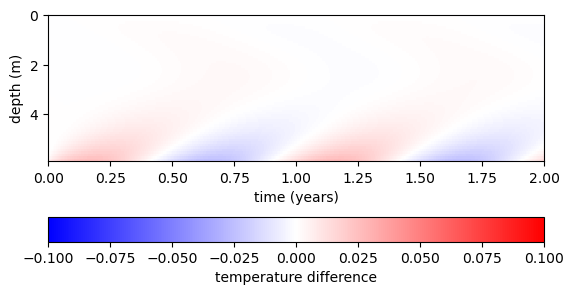

In [153]:
fig, ax = plt.subplots()
im = ax.imshow(T.T-Tana.T, extent=[0, 2, max(x), min(x)], 
               interpolation="nearest", cmap="bwr", vmin=-.1, vmax=.1)
fig.colorbar(im, orientation="horizontal", label="temperature difference")
ax.set_aspect(.1)
ax.set_xlabel("time (years)")
ax.set_ylabel("depth (m)")